# MSCA ML Final Project: Face-to-BMI
# Part 2: Image Embedding and Basic VGG

Deliverables:

1-You must create a simple web API to predict a user's BMI in real-time. You can also use webcam input. The goal is to use one of the pre-trained image models (e.g. VGG Face), fine-tune with the provided data, and deploy via jupyter notebook, streamlit, flask or any other simple restful api's.

2-10 pages of the write-up about your implementation.

3-10 mins presentation or live demo in the final lecture.

Our goal is to beat the performance metrics provided in the paper.

## Set-up

### Prepare basics

In [1]:
# colab mount
import os
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')
path_gdrive = '/content/drive/MyDrive/Colab Datasets/ML/BMI'
os.chdir(path_gdrive)
print(os.getcwd())

Mounted at /content/drive/
/content/drive/MyDrive/Colab Datasets/ML/BMI


In [2]:
# from pathlib import Path
# # create metrics, model dirs
# Path('./metrics').mkdir(parents = True, exist_ok = True)
# Path('./saved_model').mkdir(parents = True, exist_ok = True)

In [3]:
'''import os

# Google Bucket
bucket_path = 'gs://msca-sp23-bucket/ml_data'
file = 'BMI-20230313T174553Z-001.zip'
runtime_path = '/home/jupyter/data/ml/BMI'

os.chdir(runtime_path)
print(os.getcwd())'''

"import os\n\n# Google Bucket\nbucket_path = 'gs://msca-sp23-bucket/ml_data'\nfile = 'BMI-20230313T174553Z-001.zip'\nruntime_path = '/home/jupyter/data/ml/BMI'\n\nos.chdir(runtime_path)\nprint(os.getcwd())"

In [4]:
import sys
import os
import pandas as pd
import numpy as np

import re
from tqdm import tqdm

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [6]:
# read csv file
#bmi = pd.read_csv(runtime_path + '/all_data.csv')
bmi = pd.read_csv(path_gdrive + '/all_data.csv')
bmi.head(2)

,name,path,bmi,gender,is_training,imgae_type
0,img_0.bmp,Data/Images/img_0.bmp,34.207396,Male,1,bmp
1,img_1.bmp,Data/Images/img_1.bmp,26.453720,Male,1,bmp


In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.12.0
Keras version: 2.12.0


In [9]:
#!pip install keras_vggface

### Prepare Keras

In [10]:
# !python --version

In [11]:
# import site

# site_packages_path = site.getsitepackages()[0]
# print(site_packages_path)

In [12]:
# @https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
! pip install git+https://github.com/rcmalli/keras-vggface.git
! pip install keras_applications --no-deps

# filename = "/opt/conda/envs/nlp/lib/python3.10/site-packages/keras_vggface/models.py" # for gcp
filename = "/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py" # for colab
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'keras.utils.layer_utils'))

! pip install opencv-python
! pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-6buc41wx
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-6buc41wx
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8298 sha256=4f9a9e913c4e042d9a5f43113e236f6c1423897b10e72555fe135e61dd6c3b33
  Stored in directory: /tmp/pip-ephem-wheel-cache-ddd0wl9b/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/sim

## Helper Functions

### General Functions

In [13]:
# keras vggface model
import tensorflow as tf
from keras.layers import Flatten, Dense, Input, Dropout, Activation, BatchNormalization

from keras_vggface.vggface import VGGFace
from keras.models import Model
# example of loading an image with the Keras API
# since 2021 tensorflow updated the package and moved model directory
from tensorflow.keras.preprocessing import image
import keras_vggface.utils as utils

# image manipulation
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2

# face alignment
from mtcnn.mtcnn import MTCNN

# model metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# common packages
import os
import numpy as np
import pandas as pd
import pickle

import shutil

# Operations regarding to folder/file
def copy_images(file_paths, source_folder, destination_folder):
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        source_file = os.path.join(source_folder, file_name)
        destination_file = os.path.join(destination_folder, file_name)
        shutil.copyfile(source_file, destination_file)

def get_file_names(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

# Easy-to-use Performance metrics
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))

def mae(x,y):
    return mean_absolute_error(x,y)

def auc(label, pred):
    return roc_auc_score(label, pred)


# Previous codes for image2array processing; still adopted for single imgae prediction
def imgs_to_array(img_paths, version=1):
    ''' extract features from all images and convert to multi-dimensional array
    Takes:
        img_path: str
        version: int
    Returns:
        np.array
    '''
    imgs = []
    for img_path in img_paths: # += is equivalent to extend @http://noahsnail.com/2020/06/17/2020-06-17-python%E4%B8%ADlist%E7%9A%84append,%20extend%E5%8C%BA%E5%88%AB/
        imgs += [img_to_array(img_path, version)]
    return np.concatenate(imgs)

def process_array(arr, version):
    '''array processing (resize)
    Takes: arr: np.array
    Returns: np.array
    '''
    img = cv2.resize(arr, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = utils.preprocess_input(img, version=version)
    return img

def img_to_array(img_path, version):
    '''conver a SINGLE image to array
    Takes: img_path: str
    Returns: np.array
    '''
    if not os.path.exists(img_path):
        return None  

    img = image.load_img(img_path)
    img = image.img_to_array(img)
    img = process_array(img, version)
    return img

def crop_img(img,x,y,w,h):
    '''crop image
    Takes: img: np.array
           x,y,w,h: int
    Returns: np.array
    '''
    return img[y:y+h,x:x+w,:]

def img_data_generator(data, bs, img_dir, train_mode=True, version = 1): #replace function name later
    """data input pipeline
    Takes:
        data: pd.DataFrame
        bs: batch size
        img_dir: str, directory to the images
        train_mode: bool, if False, take samples from test set to aoivd overfitting
        version: int, keras_vggface version
    Returns:
        features: tuple of (x,y): features and targets
    """
    loop = True
     
    while loop:
        if train_mode:
            x = imgs_to_array(data['path'], version)
            y = data['bmi'].values
            features = (x,y)
        else:
            if len(data) >= bs:
                sampled = data.iloc[:bs,:]
                data = data.iloc[bs:,:]
                features = imgs_to_array(sampled['index'],img_dir, version)
            else: 
                loop = False
        yield features

### Prediction Class

In [14]:
# Build a prediction class

class FacePrediction(object):

    def __init__(self, img_dir, model_type='vgg16'):
        self.model_type = model_type
        self.img_dir = img_dir
        self.detector = MTCNN()
        if model_type in ['vgg16', 'vgg16_fc6']: # we might use other models, but in that case we need to just version input
            self.version = 1
        else:
            self.version = 2

    def define_model(self, hidden_dim = 64, drop_rate=0.0, freeze_backbone = True): # replace function name later
        ''' initialize the vgg model
        Reference:
            @https://zhuanlan.zhihu.com/p/53116610
            @https://zhuanlan.zhihu.com/p/26934085
        '''
        if self.model_type == 'vgg16_fc6':
            vgg_model = VGGFace(model = 'vgg16', include_top=True, input_shape=(224, 224, 3))
            last_layer = vgg_model.get_layer('fc6').output
            flatten = Activation('relu')(last_layer)
        else:
            vgg_model = VGGFace(model = self.model_type, include_top=False, input_shape=(224, 224, 3))
            last_layer = vgg_model.output
            flatten = Flatten()(last_layer)
        
        if freeze_backbone: # free the vgg layers to fine-tune
            for layer in vgg_model.layers:
                layer.trainable = False
                
        def model_init(flatten, name):
            x = Dense(64, name=name + '_fc1')(flatten)
            x = BatchNormalization(name = name + '_bn1')(x)
            x = Activation('relu', name = name+'_act1')(x)
            x = Dropout(0.2)(x)
            #x = Dense(64, name=name + '_fc2')(x)
            #x = BatchNormalization(name = name + '_bn2')(x)
            #x = Activation('relu', name = name+'_act2')(x)
            #x = Dropout(drop_rate)(x)
            #x = flatten
            return x
        
        x = model_init(flatten, name = 'bmi')
        bmi_pred = Dense(1, activation='linear', name='bmi')(x) #{'relu': , 'linear': terrible}

        custom_vgg_model = Model(vgg_model.input, bmi_pred)
        custom_vgg_model.compile('adam', 
                                 {'bmi':'mae'}, #{'bmi':'mae'},
                                 loss_weights={'bmi': 1})

        self.model = custom_vgg_model

    def train(self, train_gen, val_gen, train_step, val_step, bs, epochs, callbacks):
        ''' train the model
        Takes: 
            train_data: dataframe
            val_data: dataframe
            bs: int, batch size
            epochs: int, number of epochs
            callbacks: list, callbacks
        Recall the input for img_data_generator: data, bs, img_dir, train_mode=True, version = 1
        '''
        self.model.fit_generator(train_gen, train_step, epochs=epochs,
                                 validation_data=val_gen, validation_steps=val_step,
                                 callbacks=callbacks)


    def evaluate_perf(self, val_data):
        img_paths = val_data['path'].values
        arr = imgs_to_array(img_paths, self.version)
        bmi = self.model.predict(arr)
        metrics = {'bmi_mae':mae(bmi[:,0], val_data.bmi.values)}
        return metrics
    
    def detect_faces(self, img_path, confidence):
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        box = self.detector.detect_faces(img)
        box = [i for i in box if i['confidence'] > confidence]
        res = [crop_img(img, *i['box']) for i in box]
        res = [process_array(i, self.version) for i in res]
        return box, res

    def predict(self, img_dir, input_generator=None, input_df=None, show_img=False):
        if os.path.isdir(img_dir) and input_generator is not None:
            # Predict using the data generator
              preds = self.model.predict_generator(input_generator)

              if show_img and (input_df is not None):
                  bmi = preds
                  num_plots = len(input_df['path'])
                  ncols = 5
                  nrows = int((num_plots - 0.1) // ncols + 1)
                  fig, axs = plt.subplots(nrows, ncols)
                  fig.set_size_inches(3 * ncols, 3 * nrows)
                  for i, img_path in enumerate(input_df['path']):
                      col = i % ncols
                      row = i // ncols
                      img = plt.imread(img_path)
                      axs[row, col].imshow(img)
                      axs[row, col].axis('off')
                      axs[row, col].set_title('BMI: {:3.1f}'.format(bmi[i, 0], fontsize=10))
              return preds

        else:
            img_path = img_dir
            arr = img_to_array(img_path, self.version)
            preds = self.model.predict(arr)
            return preds


    def predict_df(self, img_dir):
        assert os.path.isdir(img_dir), 'input must be directory'
        fnames = os.listdir(img_dir)
        bmi = self.predict(img_dir)
        results = pd.DataFrame({'img':fnames, 'bmi':bmi[:,0]})
        return results
    
    def save_weights(self, model_dir):
        self.model.save_weights(model_dir)
        
    def load_weights(self, model_dir):
        self.model.load_weights(model_dir)

    def load_model(self, model_dir):
        self.model.load_model(model_dir)

    def predict_faces(self, img_path, show_img = True, color = "white", fontsize = 12, 
                      confidence = 0.95, fig_size = (16,12)):
        
        assert os.path.isfile(img_path), 'only single image is supported'
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        boxes, faces = self.detect_faces(img_path, confidence)
        preds = [self.model.predict(face) for face in faces]
        
        if show_img:
            # Create figure and axes
            num_box = len(boxes)
            fig,ax = plt.subplots()
            fig.set_size_inches(fig_size)
            # Display the image
            ax.imshow(img)
            ax.axis('off')
            # Create a Rectangle patch
            for idx, box in enumerate(boxes):
                bmi = preds[idx]
                box_x, box_y, box_w, box_h = box['box']
                rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1,edgecolor='yellow',facecolor='none')
                ax.add_patch(rect)
                ax.text(box_x, box_y, 
                        'BMI:{:3.1f}'.format(bmi[0,0]),
                       color = color, fontsize = fontsize)
            plt.show()

        return preds

## Training

### Data split

In [15]:
df = bmi[['bmi', 'gender', 'is_training', 'path', 'name']] #.sample(800)
df.head()

,bmi,gender,is_training,path,name
0,34.207396,Male,1,Data/Images/img_0.bmp,img_0.bmp
1,26.453720,Male,1,Data/Images/img_1.bmp,img_1.bmp
2,38.732782,Male,1,Data/Images/img_10.bmp,img_10.bmp
3,29.834105,Male,1,Data/Images/img_100.bmp,img_100.bmp
4,42.240827,Male,1,Data/Images/img_1000.bmp,img_1000.bmp


In [16]:
# set configs
#all_images_path = os.listdir('/home/jupyter/data/ml/BMI/') # for gcp
all_images_path = os.listdir(path_gdrive) # for colab

# split train, test; note that test set is not used for traning
train_set = df[df.is_training==1]
test_set = df[df.is_training==0] 

### Generating Data

#### Get mean pixel value

In [17]:
# import numpy as np
# import os
# from PIL import Image
# from tqdm import tqdm

# # Define the directory containing your images
# img_dir = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Images'

# # Initialize variables
# pixel_sum = 0
# num_pixels = 0

# # Count the total number of images in the directory
# total_images = len(os.listdir(img_dir))

# # Iterate over the images in the directory with a progress bar
# for image_file in tqdm(os.listdir(img_dir), total=total_images, desc='Calculating mean pixel value'):
#     image_path = os.path.join(img_dir, image_file)
#     image = Image.open(image_path)
#     pixels = np.array(image)
    
#     # Update variables
#     pixel_sum += np.sum(pixels)
#     num_pixels += pixels.size

# # Calculate the mean pixel value
# mean_pixel_value = pixel_sum / num_pixels


In [18]:
#mean_pixel_value
#110.45769021234038

#### Image Data Generator

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mean_pixel_value = 110.0

img_dir = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Images'

# Create the ImageDataGenerator for the train_data
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    #preprocessing_function=lambda x: (x - mean_pixel_value) / 255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split=0.2
)

# Create the ImageDataGenerator for the test_data
test_datagen = ImageDataGenerator(
    #preprocessing_function=lambda x: (x - mean_pixel_value) / 255.0,
    rescale = 1./255,
)

image_width, image_height = 224, 224
batch_size = 32

# Load the train data with target data
train_set_gen = train_datagen.flow_from_dataframe(
    train_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw',
    subset='training'
)

# Load the validation data with target data
validation_set_gen = train_datagen.flow_from_dataframe(
    train_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw',
    subset='validation'
)

# Load the test data with target data
test_set_gen = test_datagen.flow_from_dataframe(
    test_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw'
)

Found 2568 validated image filenames.
Found 642 validated image filenames.
Found 752 validated image filenames.


#### Get generator for 'Extra_test_images'

In [20]:
# Filter a small subset of images from test
extra_images_df = bmi.head(10)
extra_images_paths = extra_images_df['path'].tolist()

path = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/'
extra_images_df['path'] = extra_images_df['name'].apply(lambda x: path+x)

<ipython-input-20-38056d3f8171>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_images_df['path'] = extra_images_df['name'].apply(lambda x: path+x)


In [21]:
# import shutil

# def copy_images(file_paths, source_folder, destination_folder):
#     for file_path in file_paths:
#         file_name = os.path.basename(file_path)
#         source_file = os.path.join(source_folder, file_name)
#         destination_file = os.path.join(destination_folder, file_name)
#         shutil.copyfile(source_file, destination_file)

# # List of file paths
# file_paths = extra_images_paths

# # Source and destination folders
# source_folder = "/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Images"
# destination_folder = "/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images"

# # Copy the images
# copy_images(file_paths, source_folder, destination_folder)

In [22]:
# Load the test data with target data
extra_test_set_gen = test_datagen.flow_from_dataframe(
    extra_images_df,
    directory='/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images',
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw'
)

Found 10 validated image filenames.


In [23]:
extra_images_df

,name,path,bmi,gender,is_training,imgae_type
0,img_0.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_0.bmp,34.207396,Male,1,bmp
1,img_1.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1.bmp,26.453720,Male,1,bmp
2,img_10.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_10.bmp,38.732782,Male,1,bmp
3,img_100.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_100.bmp,29.834105,Male,1,bmp
4,img_1000.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1000.bmp,42.240827,Male,1,bmp
5,img_1001.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1001.bmp,36.045506,Male,1,bmp
6,img_1002.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1002.bmp,31.166739,Male,1,bmp
7,img_1003.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1003.bmp,23.565095,Male,1,bmp
8,img_1004.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1004.bmp,43.222990,Female,1,bmp
9,img_1005.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1005.bmp,29.128536,Female,1,bmp


### Train Model

In [24]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'
model_tag = 'base'
model_id = '{:s}_{:s}'.format(model_type, model_tag)

#model_dir = '/home/anthony/projects/dl_image_bmi/saved_models/saved_model_{:s}.h5'.format(model_id) # gcp
#model_dir = './saved_models/saved_model_{:s}.h5'.format(model_id) # colab
model_dir = './saved_models/saved_model_small_sample_{:s}.h5'.format(model_id) # colab

bs = 8
epochs = 20
freeze_backbone = True # True => transfer learning; False => train from scratch

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=False, verbose=1)
tb = TensorBoard('./tb/%s'%(model_id))
callbacks = [es, ckp]

In [26]:
%%time

model = FacePrediction(img_dir = all_images_path, model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
model.model.summary()

58909280/58909280 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                            

In [27]:
%%time

if mode == 'train':
    model_history = model.train(train_set_gen, validation_set_gen,3,3, bs = bs, epochs = epochs, callbacks = callbacks)
else: 
    model.load_weights(model_dir)

<ipython-input-14-b7e4255f8f43>:65: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(train_gen, train_step, epochs=epochs,


Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 30.5543
Epoch 1: val_loss improved from inf to 32.72271, saving model to ./saved_models/saved_model_small_sample_vgg16_base.h5
3/3 [==============================] - 58s 18s/step - loss: 30.5543 - val_loss: 32.7227
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 32.3351
Epoch 2: val_loss improved from 32.72271 to 31.22903, saving model to ./saved_models/saved_model_small_sample_vgg16_base.h5
3/3 [==============================] - 43s 18s/step - loss: 32.3351 - val_loss: 31.2290
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 30.6434
Epoch 3: val_loss did not improve from 31.22903
3/3 [==============================] - 35s 14s/step - loss: 30.6434 - val_loss: 33.1580
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 33.6098
Epoch 4: val_loss did not improve from 31.22903
3/3 [==============================] - 34s 14s/step - loss: 33.6098 - val_loss: 31.4704
Epoch 5/20
3/

### Load Model

In [28]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Colab Datasets/ML/BMI/saved_models/saved_model_small_sample_vgg16_base.h5'

# load model
loaded_model = load_model(model_path)

In [29]:
#model.load_weights(model_dir)
#model.load_weights(model_dir_2)

## Evaluations

In [30]:
y_test = test_set_gen.labels

In [31]:
#?loaded_model
#type(loaded_model)

In [32]:
#preds = model.predict(img_dir, test_set_gen, show_img=False)
#preds = loaded_model.predict(img_dir, test_set_gen, show_img=False)
#loaded_model_preds = model.predict(img_dir, test_set_gen, show_img=False)

In [33]:
model_preds = model.predict(img_dir, test_set_gen, show_img=False)

<ipython-input-14-b7e4255f8f43>:89: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(input_generator)


In [34]:
#type(preds[0])
model_y_preds = model_preds
#loaded_model_y_preds = loaded_model_preds

In [35]:
#model_y_preds

In [36]:
rmse(y_test, model_y_preds) 
# 32.433900777299876
# 28.xxx
# 36.0457
# 15.271164972603007 for saved_model_small_sample_vgg16_base_extra_zero
# 14 for full sample no layer

34.489443988445124

In [37]:
#rmse(y_test, loaded_model_y_preds)

In [38]:
mae(y_test, model_y_preds)

33.235861650433804

In [39]:
#mae(y_test, loaded_model_y_preds)

## Prediction

In [40]:
# single_test_img = '/home/jupyter/data/ml/BMI/Images/img_1001.bmp' #gcp
single_test_img = path_gdrive + '/Data/Images/img_1001.bmp' #colab
model.predict(single_test_img)

1/1 [==============================] - 1s 632ms/step


array([[90.48742]], dtype=float32)

<ipython-input-14-b7e4255f8f43>:89: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(input_generator)


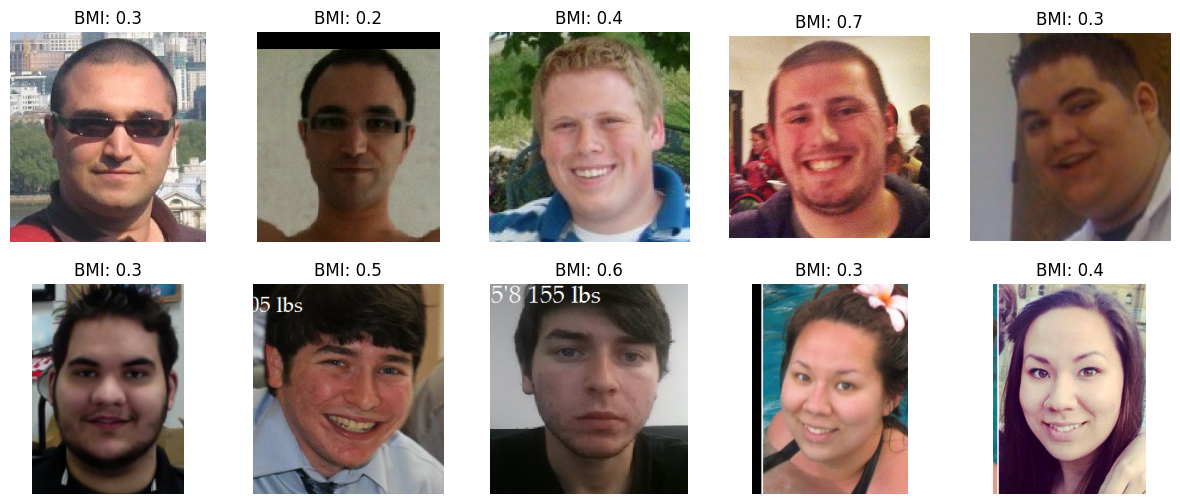

In [41]:
# Call the predict function
img_dir = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images'
show_img = True
predictions = model.predict(img_dir, input_generator=extra_test_set_gen, input_df=extra_images_df, show_img=show_img)